In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


In [32]:
from models import Models
from models_dict_v2 import model_dict
from generate_synthetic_df import generate_synthetic_df

# Create synthetic dataframe
df = generate_synthetic_df(100, 0)

# Instantiate an object from the class "Models"
models = Models(model_dict)

# Calculate the cost and price
cost = models.calculate_cost(df)
pricing = models.calculate_pricing(df)

# Calculate the profit on the synthetic dataframe
df["profit"] = models.calculate_profit(cost, pricing)

# Create identification variable
df["id"] = np.tile(np.arange(100), 1)

# Create time period variable
df["time"] = 0

# Do one-hot encoding on the categorical variables
df = pd.get_dummies(df)
df = df.drop("MARITAL_STATUS_Not_Single", axis=1)

In [33]:
# slipt to X and y variables
y = df["profit"]
X = df.drop(["profit","id","time"], axis = 1)

In [127]:
#convert Matrital_Status to binary; single - 0; non-single - 1; 

#value_to_replace = "Single"
#replacement_value = 0
#X['MARITAL_STATUS'] = X['MARITAL_STATUS'].replace(value_to_replace, replacement_value)

In [13]:
#convert Matrital_Status to binary; single - 0; non-single - 1; 

#value_to_replace = "Single"
#replacement_value = 0
#X['MARITAL_STATUS'] = X['MARITAL_STATUS'].replace(value_to_replace, replacement_value)

#value_to_replace = "Not_Single"
#replacement_value = 1
#X['MARITAL_STATUS'] = X['MARITAL_STATUS'].replace(value_to_replace, replacement_value)

In [54]:
# split to training and validation data 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
reg_tree = DecisionTreeRegressor(max_depth=3)  # You can adjust hyperparameters like max_depth


In [35]:
#reg_tree.fit(X_train, y_train)
reg_tree.fit(X, y)

DecisionTreeRegressor(max_depth=3)

In [131]:
#make prediction 
#y_pred = reg_tree.predict(X_test)
#mse = mean_squared_error(y_test, y_pred)
#print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 1996.1327


In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

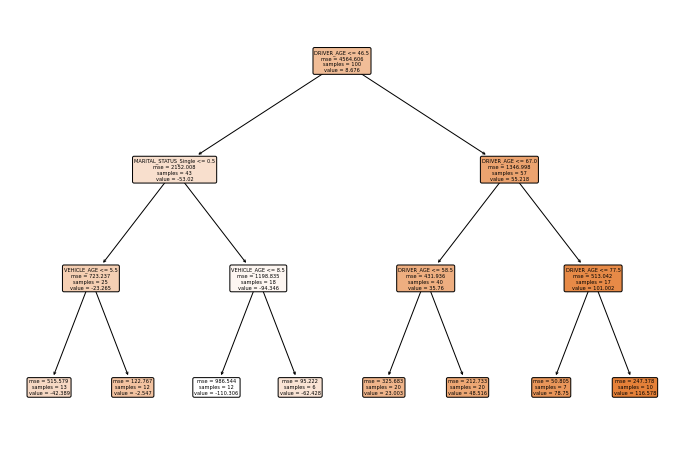

In [36]:
# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(reg_tree, filled=True, feature_names=X.columns, rounded=True)
plt.show()

In [19]:
def get_state(regressor):
    #Source: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    #This method takes our regressor as input and returns an array of boolean plus an array of integers.
    #The array of booleans will have the length same as the total number of nodes and will indicate if each is a leaf.
    #The array of integers will have the same length as the total number of leaves and will correspond to the location of "True" in the boolean array.
    
    regressor_tree = regressor.tree_

    n_nodes = regressor_tree.node_count
    children_left = regressor_tree.children_left
    children_right = regressor_tree.children_right

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True
    
    print(is_leaves)
    return is_leaves, np.nonzero(is_leaves)[0]

is_leaves, states = get_state(reg_tree)
print(states)
print(len(states))

[False False False  True  True False  True  True False False  True  True
 False  True  True]
[ 3  4  6  7 10 11 13 14]
8


In [37]:
def get_leaf_indices(tree):
    """ Return the indices of the leaf nodes in the decision tree. """
    return np.where(tree.tree_.children_left == tree.tree_.children_right)[0]

# Get the leaf node indices for the trained regressor
states = get_leaf_indices(reg_tree)
print(f"Leaf Nodes states: {states}")


Leaf Nodes states: [ 3  4  6  7 10 11 13 14]


In [38]:
def extract_leaf_values(regressor):
    # Return the values in the leaves of the decision tree
    return regressor.tree_.value.squeeze()

Profit_Vector = extract_leaf_values(reg_tree)

Profit_Vector

array([   8.67578804,  -53.01980052,  -23.26459935,  -42.38865843,
         -2.54686868,  -94.3464688 , -110.30575504,  -62.42789633,
         55.21807414,   35.75989267,   23.0034021 ,   48.51638323,
        101.00203056,   78.75005173,  116.57841575])

In [39]:
# apply to each client into each state

def get_state_of_one_year(x, regressor, states):
    x_leaf_id = regressor.apply(x)
    x_states = np.empty(len(x), dtype = np.uint16)
    for k in range(len(x)):
        x_states[k] = np.where(states == x_leaf_id[k])[0][0]
    return x_states

df["state"] = get_state_of_one_year(X, reg_tree, states)
df

,ANNUAL_KILOMETERS_QUANTITY,DRIVER_AGE,VEHICLE_AGE,VEHICLE_PRICE,DRIVER_TRAINING_INDICATOR_PRINCIPAL,LEASED_VEHICLE_INDICATOR,NUMBER_OF_CLAIMS_PAST_5YEARS,NUMBER_OF_MINOR_CONVICTIONS_PAST_3YEARS,profit,id,time,MARITAL_STATUS_Single,state
0,24348,82,4,628,False,False,0,0,110.348016,0,0,0,7
1,14801,27,5,33239,False,False,0,0,-66.995161,1,0,0,0
2,18851,28,13,13700,False,False,0,0,-4.442560,2,0,0,1
3,27686,66,10,7518,True,True,0,0,65.066674,3,0,1,5
4,25072,30,10,22330,False,False,0,0,-65.328264,4,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16946,47,13,6623,False,False,0,0,37.958626,95,0,0,4
96,12073,63,7,24437,True,False,3,0,21.753299,96,0,0,5
97,24501,63,10,27552,False,False,0,0,47.087766,97,0,1,5
98,12888,86,4,31132,False,False,1,0,125.165869,98,0,0,7


In [25]:
# apply to group 
#leaf_index = reg_tree.apply(X, True)

#add leaf index 
#X_with_leaf = X.copy()
#X_with_leaf["group"] = leaf_index
#print(X_with_leaf)



In [26]:
# Function to recursively extract rules from the tree
#def extract_rules(tree, feature_names, class_names, node=0):
#    if tree.children_left[node] == tree.children_right[node]:  # Leaf node
#        class_idx = np.argmax(tree.value[node])
#        rule = f"Class: {class_names[class_idx]}"
#    else:
#        feature_idx = tree.feature[node]
#        threshold = tree.threshold[node]
#        rule = f"If {feature_names[feature_idx]} <= {threshold:.2f}: "
#        rule += extract_rules(tree, feature_names, class_names, tree.children_left[node])
#        rule += f"\nElse: {extract_rules(tree, feature_names, class_names, tree.children_right[node])}"
#    return rule

# Extract rules from the decision tree
#tree_rules = extract_rules(reg_tree.tree_, X.columns, y)

#print(tree_rules)

In [42]:
# step 2: construct new datasets using different seed 

# Create synthetic dataframe
df1 = generate_synthetic_df(100, 10)

# Create identification variable
df1["id"] = np.tile(np.arange(100), 1)

# Create time period variable
df1["time"] = 1

# Do one-hot encoding on the categorical variables
df1 = pd.get_dummies(df1)
df1 = df1.drop("MARITAL_STATUS_Not_Single", axis=1)

# take Xs 
X1 = df1.drop(["id","time"], axis = 1)

df1["state"] = get_state_of_one_year(X1, reg_tree, states)


df1

,ANNUAL_KILOMETERS_QUANTITY,DRIVER_AGE,VEHICLE_AGE,VEHICLE_PRICE,DRIVER_TRAINING_INDICATOR_PRINCIPAL,LEASED_VEHICLE_INDICATOR,NUMBER_OF_CLAIMS_PAST_5YEARS,NUMBER_OF_MINOR_CONVICTIONS_PAST_3YEARS,id,time,MARITAL_STATUS_Single,state
0,21321,51,7,23308,False,False,0,2,0,1,0,4
1,17006,17,14,24674,False,False,0,0,1,1,1,3
2,1182,34,0,12360,True,False,0,1,2,1,1,2
3,11941,57,7,7354,False,False,3,0,3,1,1,4
4,16349,47,0,9814,False,False,2,0,4,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
95,18427,71,9,23846,False,False,0,0,95,1,1,6
96,8625,66,8,3663,False,False,0,0,96,1,1,5
97,12627,32,6,100,False,False,0,0,97,1,0,1
98,17788,69,7,12068,False,False,0,0,98,1,1,6


In [45]:
dfmerge = df.merge(df1[["id", "state"]], on='id', how = 'inner')

def compute_transition_matrix(df):
    # Create a crosstab table (transition counts)
    cross_tab = pd.crosstab(df['state_x'], df['state_y'])
   
    # Convert counts to probabilities (normalize rows to sum to 1)
    transition_matrix = cross_tab.div(cross_tab.sum(axis=1), axis=0)
   
    return transition_matrix

# Compute the transition matrix
transition_matrix = compute_transition_matrix(dfmerge)

print(transition_matrix)


state_y         0         1         2         3         4         5         6  \
state_x                                                                         
0        0.307692  0.076923  0.000000  0.153846  0.153846  0.153846  0.153846   
1        0.166667  0.083333  0.166667  0.083333  0.083333  0.416667  0.000000   
2        0.000000  0.083333  0.083333  0.083333  0.333333  0.250000  0.166667   
3        0.166667  0.000000  0.000000  0.166667  0.333333  0.000000  0.166667   
4        0.100000  0.150000  0.150000  0.050000  0.250000  0.150000  0.100000   
5        0.100000  0.300000  0.050000  0.100000  0.150000  0.050000  0.150000   
6        0.000000  0.000000  0.428571  0.142857  0.142857  0.142857  0.000000   
7        0.200000  0.000000  0.000000  0.000000  0.600000  0.100000  0.100000   

state_y         7  
state_x            
0        0.000000  
1        0.000000  
2        0.000000  
3        0.166667  
4        0.050000  
5        0.100000  
6        0.142857  
7        

In [ ]:
a = np.unique(df.to_numpy())
transitionMatrix = pd.crosstab(df['state'], df1['state']).reindex(columns=a, index=a, fill_value=0)
print(transitionMatrix)

In [135]:
# step 3: construct transition matrix 

# Extract initial state from X_with_leaf
initial_state = X_with_leaf['group'].tolist()

# Helper function to compute individual transition matrix between two states
def compute_transition_matrix(initial_state, next_state):
    # Create an empty transition matrix
    unique_states = list(set(initial_state) | set(next_state))
    matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)
   
    # Populate the matrix with transition counts
    for i, initial in enumerate(initial_state):
        matrix.at[initial, next_state[i]] += 1
       
    # Convert counts to probabilities
    matrix = matrix.div(matrix.sum(axis=1), axis=0)
   
    return matrix

# Compute the transition matrices for transitions between X_with_leaf and each dataframe in df_dict_with_groups
transition_matrices = {}
current_state = initial_state

for i in range(len(testdata)):
    next_state = testdata[i]['group'].tolist()
    transition_matrices[i] = compute_transition_matrix(current_state, next_state)
    current_state = next_state  # Set the next state to be the current state for the next loop

# Displaying the transition matrix for the first transition (i.e., from X_with_leaf to df_dict_with_groups[0])
print(transition_matrices[0])

      3     4    5    8     9    11    12
3   0.00  0.00  0.0  1.0  0.00  0.0  0.00
4   0.25  0.25  0.0  0.0  0.25  0.0  0.25
5   0.00  0.00  0.0  0.0  0.00  0.0  1.00
8   0.00  1.00  0.0  0.0  0.00  0.0  0.00
9   0.00  1.00  0.0  0.0  0.00  0.0  0.00
11  0.00  1.00  0.0  0.0  0.00  0.0  0.00
12  0.00  0.00  0.0  1.0  0.00  0.0  0.00


In [137]:
testdata[4]

,ANNUAL_KILOMETERS_QUANTITY,DRIVER_AGE,VEHICLE_AGE,VEHICLE_PRICE,DRIVER_TRAINING_INDICATOR_PRINCIPAL,LEASED_VEHICLE_INDICATOR,MARITAL_STATUS,NUMBER_OF_CLAIMS_PAST_5YEARS,NUMBER_OF_MINOR_CONVICTIONS_PAST_3YEARS,group
0,1077,52,4,27047,True,False,0,0,0,3
1,11783,64,7,29722,False,False,1,0,0,12
2,7653,61,4,100,False,False,0,0,0,8
3,1747,44,6,20350,False,False,0,0,0,3
4,21883,33,7,23288,False,False,1,0,0,4
5,8662,77,8,18998,False,False,0,0,0,11
6,6536,106,5,11538,False,True,0,1,0,8
7,19491,66,17,30106,False,False,0,1,0,11
8,3023,52,6,8131,False,False,0,0,0,3
9,2707,62,11,19133,False,False,1,1,0,12


In [122]:
X_with_leaf[X_with_leaf["group"]==14].count()

ANNUAL_KILOMETERS_QUANTITY                 10
DRIVER_AGE                                 10
VEHICLE_AGE                                10
VEHICLE_PRICE                              10
DRIVER_TRAINING_INDICATOR_PRINCIPAL        10
LEASED_VEHICLE_INDICATOR                   10
MARITAL_STATUS                             10
NUMBER_OF_CLAIMS_PAST_5YEARS               10
NUMBER_OF_MINOR_CONVICTIONS_PAST_3YEARS    10
group                                      10
dtype: int64

In [123]:
unique_states = list(set(initial_state) | set(next_state))

In [124]:
unique_states

[3, 4, 6, 7, 10, 11, 13, 14]